## Isabelle Tobin's convective aggregation classification

Uses VISST data to derive convective aggregation index

In [234]:
# Load required libraries
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import datetime
import math
import glob
import os
from skimage import measure
%matplotlib inline
from scipy import interpolate, ndimage
from copy import deepcopy

Input time for algorithm to run on

In [235]:
# Input the range of dates and time wanted for the collection of images
year = 2006
start_day = 1
start_month = 1
start_hour = 0
start_minute = 0
start_second = 0

end_month = 1
end_day = 3
end_hour = 12
end_minute = 00
end_second = 00

start_time = datetime.datetime(year,
                               start_month,
                               start_day,
                               start_hour,
                               start_minute,
                               start_second)
end_time = datetime.datetime(year,
                             end_month,
                             end_day,
                             end_hour,
                             end_minute,
                             end_second)
deltatime = end_time - start_time


if(deltatime.seconds > 0 or deltatime.minute > 0):
    no_days = deltatime.days + 1
else:
    no_days = deltatime.days

days = np.arange(0, no_days, 1)
print('We are about to load grid files for ' + str(no_days) + ' days')
data_path = '/home/rjackson/data/visst/'

# Find the list of files for each day
cur_time = start_time

file_list = []
time_list = []
for i in days:
    year_str = "%04d" % cur_time.year
    day_str = "%02d" % cur_time.day
    month_str = "%02d" % cur_time.month
    print('Looking for files with format ' +
          data_path +
          'twpvisstpx04*' +
          year_str +
          month_str +
          day_str +
          '*.cdf')
    data_list = glob.glob(data_path +
                          'twpvisstpx04*' +
                          year_str +
                          month_str +
                          day_str +
                          '*.cdf')
    file_list.append(data_list[0])
    time_list.append(cur_time)
    cur_time = cur_time + datetime.timedelta(days=1)

We are about to load grid files for 3 days
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060101*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060102*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstpx04*20060103*.cdf


In [236]:
# Convert degrees minutes seconds to decimal
def dms_to_decimal(deg, minutes, seconds):
    return deg+minutes/60+seconds/3600

# Convert seconds to midnight to a string format
def seconds_to_midnight_to_string(time_secs_after_midnight):

    hours = math.floor(time_secs_after_midnight/3600)
    minutes = math.floor((time_secs_after_midnight - hours*3600)/60)
    temp = datetime.time(int(hours), int(minutes), )
    return temp.strftime('%H%M%S')

Load image data. Mask out all regions with Tb > 240 K to only include convective regions as defined by Tobin et al. (2012)

[ 125.04000092  125.04000092  125.04000092 ...,  135.97999573  135.97000122
  135.97000122]


/home/rjackson/anaconda3/envs/pyart/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/envs/pyart/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/envs/pyart/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/envs/pyart/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/envs/pyart/lib/python2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in greater


Domain:125.0 136.0-17.0 -5.0
(1344, 1221)


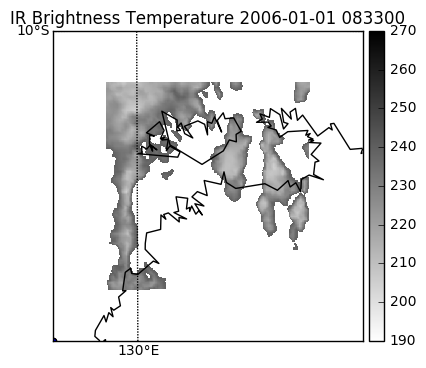

In [282]:
i = 0
cdf_data = Dataset(file_list[i], mode='r')

# Load lat, lon, and time parameters
Latitude = cdf_data.variables['latitude']
Longitude = cdf_data.variables['longitude']
Time = cdf_data.variables['image_times']
NumPixels = cdf_data.variables['image_numpix']


# Load brightness temperature
IRBrightness = cdf_data.variables['temperature_ir']

frame = 8

j = frame

convective_regions = IRBrightness < 240
Darwin_Lat = dms_to_decimal(-12, 25, 28.56)
Darwin_Lon = dms_to_decimal(130, 53, 29.75)

cpol_latitude = -12.249166
cpol_longitude = 131.04445

# Get Lat and Lon for specific frame
Lat = Latitude[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
Lon = Longitude[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
print(Lon)
# Set up projection
plt.clf()
m = Basemap(width=500000, height=500000,
            resolution='l', projection='stere',
            lat_0=cpol_latitude,
            lon_0=cpol_longitude)

xi, yi = m(Lon, Lat)
darwin_x, darwin_y = m(cpol_latitude, cpol_longitude)

# Regrid data to 2D
x,y = np.meshgrid(np.arange(min(xi),max(xi),1000),np.arange(min(yi),max(yi),1000))

index = j
data = IRBrightness[(int(j)*int(NumPixels[j])):(int(j+1)*int(NumPixels[j])-1)]
data_gridded = interpolate.griddata((xi,yi), data, (x,y))
lat_gridded = interpolate.griddata((xi,yi), Lat, (x,y))
lon_gridded = interpolate.griddata((xi,yi), Lon, (x,y))

masked_region = np.logical_or(np.logical_or(lat_gridded > cpol_latitude+1.5,lat_gridded < cpol_latitude-1.5),
                               np.logical_or(lon_gridded < cpol_longitude-1.5,lon_gridded > cpol_longitude+1.5))
masked_region = np.logical_or(masked_region, data_gridded > 240)
data_masked = np.ma.array(data_gridded)
data_masked = np.ma.masked_where(masked_region, data_gridded)

# Plot the masked data
colors = m.pcolormesh(x,y,data_masked, cmap='gray_r', vmin=190, vmax=270)
plt.text(darwin_x,
         darwin_y,
         'Darwin',
         fontweight='bold',
         color='white')
plt.plot(darwin_x*0.98, darwin_y*1.01, 'w.')

m.drawparallels(np.arange(-80., 81., 10.),
                labels=[1, 0, 0, 0],
                fontsize=10)
m.drawmeridians(np.arange(-180., 181., 10.),
                labels=[0, 0, 0, 1],
                fontsize=10)
m.drawcoastlines()
m.drawcountries()
m.colorbar()

year_str = "%04d" % year
day_str = "%02d" % time_list[i].month
month_str = "%02d" % time_list[i].day
plt.title('IR Brightness Temperature '
          + str(year)
          + '-'
          + str(day_str)
          + '-'
          + str(month_str)
          + ' '
          + seconds_to_midnight_to_string(Time[index]))

if not os.path.exists('./output_plots'):
    os.makedirs('./output_plots')

print('Domain:' + str(np.min(Lon)) + ' ' 
      + str(np.max(Lon)) + 
      str(np.min(Lat))
      + ' '
      + str(np.max(Lat)))
blobs = ~data_masked.mask

blobs_labels = measure.label(blobs, background=0)

print(blobs_labels.shape)
array = ndimage.measurements.center_of_mass(blobs, blobs_labels, [1,2,3,4,5,6,7])
m.scatter(array[0], array[1])

## Find all of the blobs in the image. Number of blobs = number of clusters

N = 17
Locations: 
[(565.33283370805225, 583.71413106836542), (812.18518518518522, 436.0), (812.0, 441.0), (811.0, 442.0), (816.27035623409665, 486.81552162849874), (779.81129296235679, 545.56906710310966), (710.36660039761432, 580.01669980119289), (604.97727272727275, 553.84848484848487), (829.90740740740739, 594.80864197530866), (570.0, 582.0), (621.17142857142858, 616.76190476190482), (763.0, 635.0), (753.72627737226276, 649.68978102189783), (767.0, 642.0), (821.60643185298625, 687.61102603369068), (686.61764705882354, 690.00980392156862), (716.16326530612241, 696.81632653061229)]


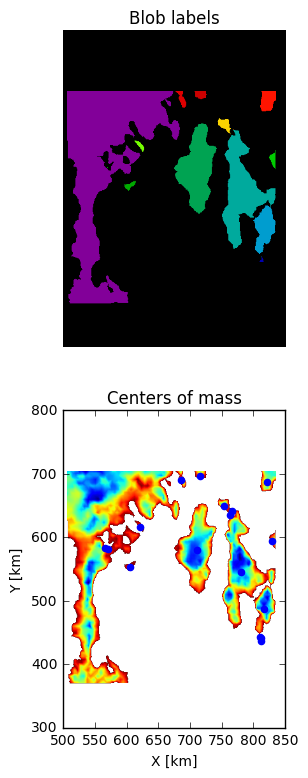

In [283]:
# Make image to where 1 = convective, 0 = not convective
blobs = deepcopy(data_masked)
blobs[~blobs.mask] = 1
blobs[blobs.mask] = 0
blobs.mask = False

# Get locations of blobs
blobs_labels, num_blobs = ndimage.measurements.label(blobs)
locs = ndimage.measurements.center_of_mass(blobs, blobs_labels, range(2, num_blobs))

# Label 0 = masked data, 1 = background, clusters start at label 2
print('N = ' + str(num_blobs-2))
List = [(elem2, elem1) for elem1, elem2 in locs]
print('Locations: ')
print(List)

# Plot the blobs
figure = plt.figure(figsize=(17,9))
plt.subplot(211)
plt.imshow(blobs_labels, cmap='spectral')
plt.title('Blob labels')
plt.axis('off')
plt.xlim((500, 850))
plt.ylim((300, 800))
plt.xlabel('X [km]')
plt.ylabel('Y [km]')

plt.subplot(212)
plt.imshow(data_masked)
plt.scatter(*zip(*List), color='b')
plt.title('Centers of mass')
plt.xlim((500, 850))
plt.ylim((300, 800))
plt.xlabel('X [km]')
plt.ylabel('Y [km]')

## Calculate SCAI N/Nmax * D/L

N = number of clusters
Nmax = theoretical maximum number of clusters
D = product of distances between cells
L = characteristic length of domain (about 350 km here)

Tobin et al. (2012) show that N is sufficient to categorize degree of aggregation,
SCAI depends on domain size and on resolution, N does not.

Expected pairs: 136
122500.0


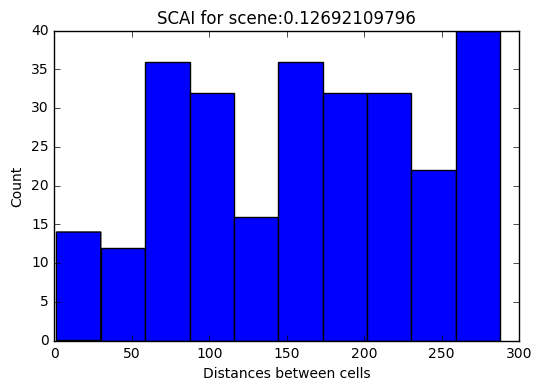

In [278]:
L = 350.0
a = 1.0
Nmax = pow((L/a),2)
print('Expected pairs: ' + str((num_blobs-2)*(num_blobs-3)/2))
distances = []
for point1 in List:
    for point2 in List:
        if(point1 != point2):
            d = math.sqrt(pow(point1[0]-point2[0],2) + pow(point1[1]-point2[1],2))
            distances.append(d)
            
n = (num_blobs-2)*(num_blobs-3)/2
d1 = 1/float(n)*np.sum(distances)
print(Nmax)
scai = ((num_blobs-2))/Nmax*d1/(L)*1000

plt.figure
plt.hist(distances)
plt.xlabel('Distances between cells')
plt.ylabel('Count')
plt.title('SCAI for scene:' + str(scai))